## Ising Model GAN

In [1]:
!wget https://raw.githubusercontent.com/pSzyc/Ising/main/Model/input_pipeline.py
!wget https://raw.githubusercontent.com/pSzyc/Ising/main/Model/GAN/model.py

--2024-02-15 08:01:28--  https://raw.githubusercontent.com/pSzyc/Ising/main/Model/input_pipeline.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2810 (2.7K) [text/plain]
Saving to: ‘input_pipeline.py.1’

input_pipeline.py.1 100%[===================>]   2.74K  --.-KB/s    in 0s      

2024-02-15 08:01:28 (20.6 MB/s) - ‘input_pipeline.py.1’ saved [2810/2810]

--2024-02-15 08:01:28--  https://raw.githubusercontent.com/pSzyc/Ising/main/Model/GAN/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3623 (3.5K) [text/plain]
Savin

In [2]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from input_pipeline import dataset_tfrecord_pipeline
import time
from IPython import display
from model import make_discriminator_model, make_generator_model, train_step
from google.colab import drive
from pathlib import Path

plt.rcParams['figure.dpi'] = 300

drive.mount('/content/drive', force_remount=True)
drive_path = Path("drive/MyDrive/Licencjat")

Mounted at /content/drive


## Load data

In [3]:
#batch_size = 64
#train_path = drive_path / 'data' / 'Data2.2.tfrecord'
#train_ds = dataset_tfrecord_pipeline(train_path, flatten=False, batch_size=batch_size)

In [4]:
size = 10000
data_path = drive_path / "data"

data_list = []
for temp in [2.0, 2.5, 3.0]:
    train_path = data_path / f'Data{temp:.2}.tfrecord'
    train_ds = dataset_tfrecord_pipeline(train_path, flatten=False, batch_size=size)
    for image in train_ds.take(1):
        data_list.append(image)

In [5]:
batch_size = 100
train_images = np.array(data_list)
train_images = np.concatenate(train_images, axis=0)
np.random.shuffle(train_images)
train_ds = tf.data.Dataset.from_tensor_slices(train_images).batch(batch_size)

## Training

In [6]:
def generate_and_save_images(model, epoch, test_input):
  predictions = tf.round(model(test_input, training=False))

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

def train(dataset, epochs, gen_loss_log, disc_loss_log):

  for epoch in range(epochs):
    start = time.time()

    for images in tqdm(dataset): train_step(images, gen_loss_log, disc_loss_log, batch_size, noise_dim, generator, discriminator, generator_optimizer, discriminator_optimizer)

    display.clear_output(wait=True)
    generate_and_save_images(
      generator,
      epoch + 1,
      random_vector_for_generation
    )
    print (f"Time taken for epoch {epoch} is {time.time()- start} sec")


noise_dim = 100
num_examples_to_generate = 16
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 noise_dim])
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

## Train the GAN!

In [7]:
EPOCHS=10
gen_loss_log=[]
disc_loss_log=[]

## Train

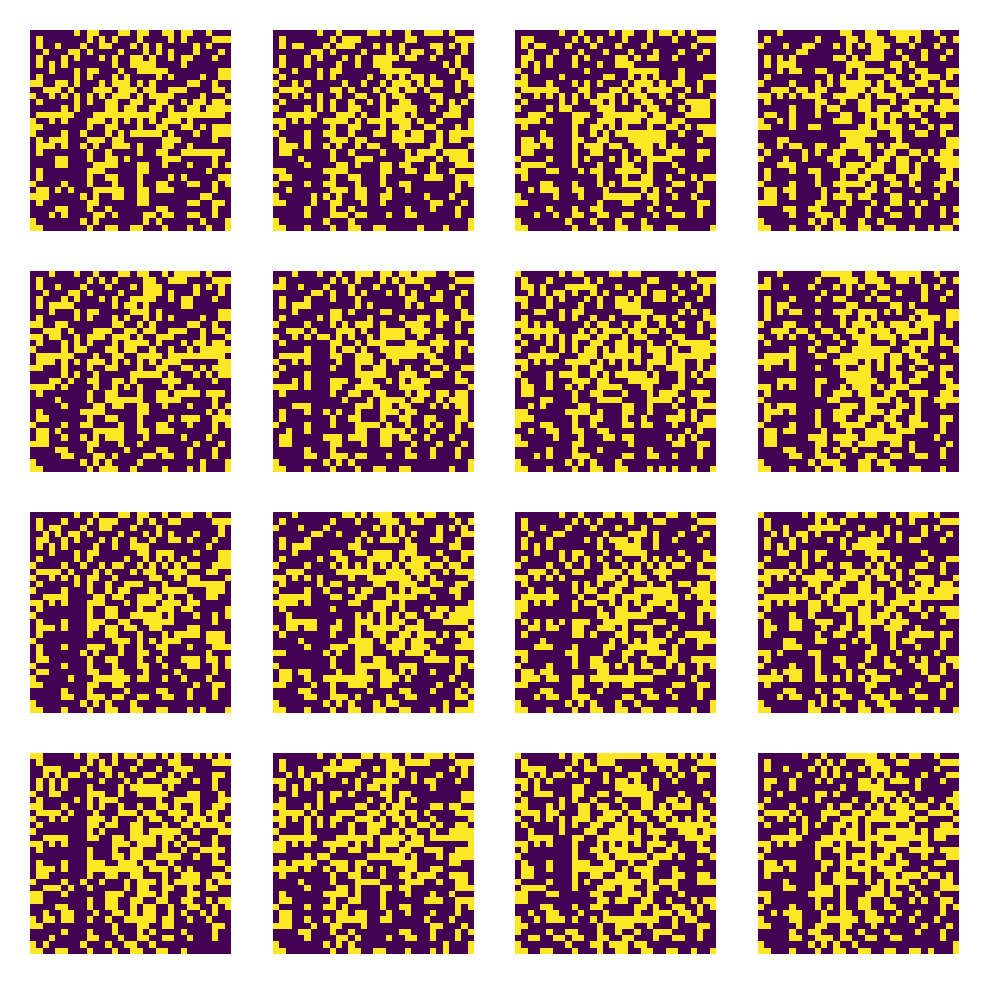

Time taken for epoch 1 is 34.6023805141449 sec


 37%|███▋      | 110/300 [00:12<00:20,  9.28it/s]

In [ ]:
%%time
train(train_ds, EPOCHS,gen_loss_log, disc_loss_log)

## Plot the loss of the generator and discriminator

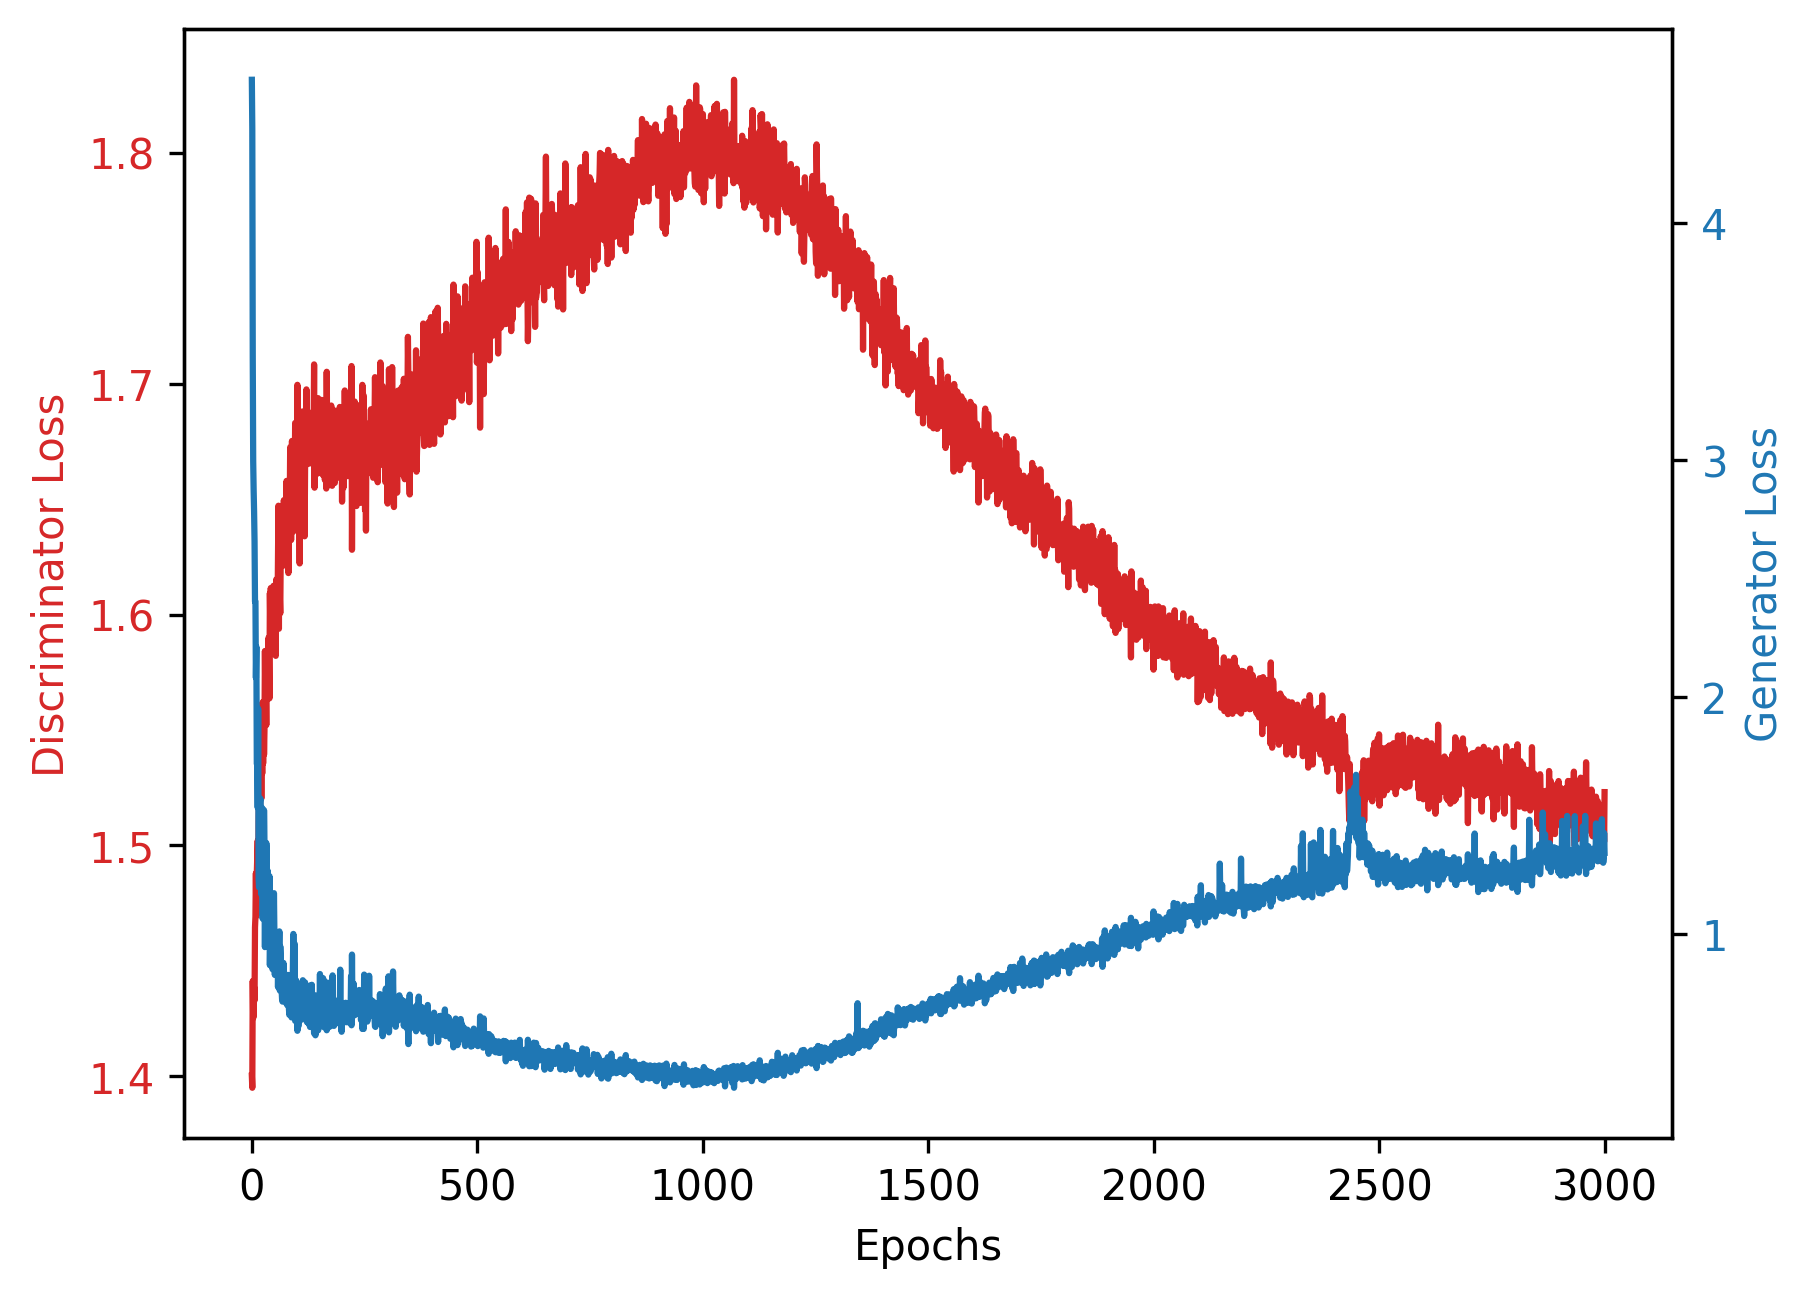

In [13]:
fig, ax1 = plt.subplots()

ax1.plot(np.asarray(disc_loss_log), color='tab:red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Discriminator Loss', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.plot(np.asarray(gen_loss_log), color='tab:blue')
ax2.set_ylabel('Generator Loss', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.show()

In [10]:
predictions = generator(random_vector_for_generation, training=False)

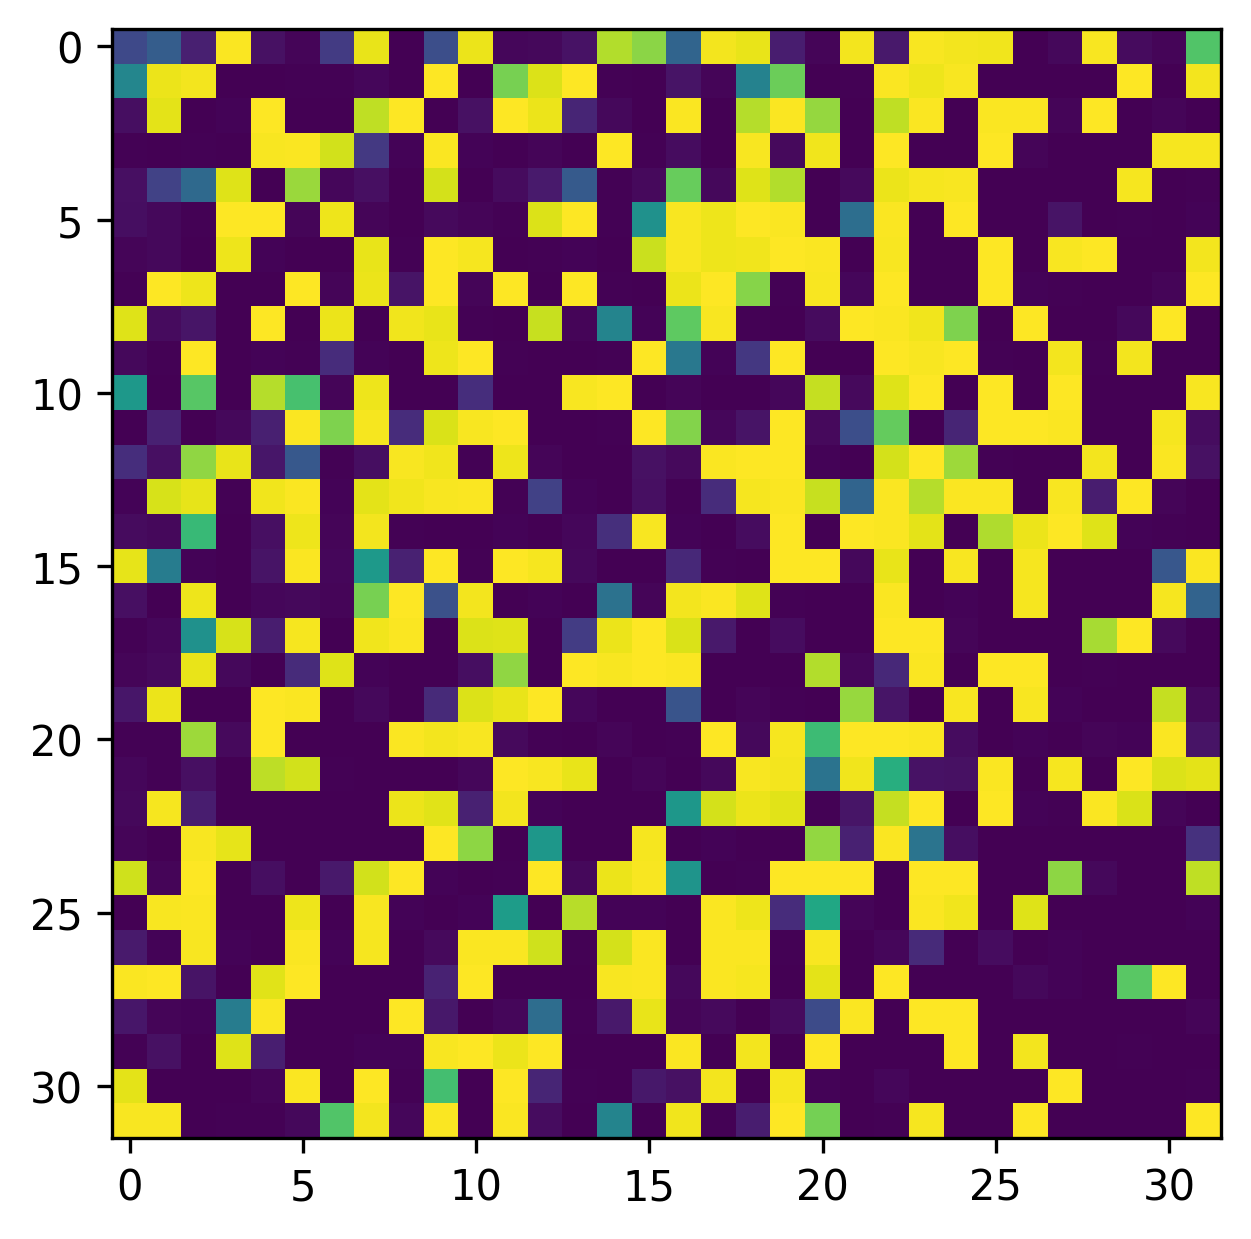

In [11]:
plt.imshow(predictions[0, :, :, 0])

In [12]:
predictions[0, :, :, 0]

<tf.Tensor: shape=(32, 32), dtype=float32, numpy=
array([[2.19775096e-01, 2.94243574e-01, 8.67022499e-02, ...,
        2.78122295e-02, 1.32231321e-02, 7.26741195e-01],
       [4.59206939e-01, 9.71524179e-01, 9.84003127e-01, ...,
        9.99247432e-01, 1.68342507e-04, 9.81094480e-01],
       [3.54102999e-02, 9.57369685e-01, 4.30102955e-04, ...,
        1.85333756e-05, 1.40774986e-02, 3.88104236e-04],
       ...,
       [4.41212161e-03, 4.59149107e-02, 1.24346046e-03, ...,
        5.38249174e-03, 9.69584798e-05, 4.64697878e-05],
       [9.59487021e-01, 1.86930620e-03, 3.39845754e-03, ...,
        3.36211524e-05, 3.82838800e-04, 6.36889180e-03],
       [9.91437137e-01, 9.88689601e-01, 1.52847453e-04, ...,
        1.00484634e-04, 2.13738624e-03, 9.98780191e-01]], dtype=float32)>